In [1]:
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor
from functools import partial
from tqdm import tqdm
import numpy as np
import torch
from sparseopt.attns.retriever import TokenSparseRetriever, chunk_topk, chunk_topk_v3, chunk_topk_v2
import os
import glob
from collections import defaultdict
from sparseopt.utils.plot import plot_hist_m
from matplotlib import pyplot as plt
from einops import rearrange

### 比较v2与v0 recall

In [3]:
def compare(data, v1, v2, ks=[128, 256, 512, 1024, 2048, 4096]):
    data['chunk_size'] = 64
    _, res_v1 = chunk_topk(**data, version=v1)
    _, res_v2 = chunk_topk(**data, version=v2)
    hit_rate = defaultdict(float)
    for k in ks:
        hit_rate[k] = (res_v1[..., :k, None] == res_v2[..., None, :]).any(-1).float().mean().item()
        # print(f"k={k}, hit_rate={hit_rate[k]:.4f}")
    return hit_rate

In [5]:
# data_dir = "/ssd01/workspace/sglang/exp/data/db_idx/"
data_dir = "/ssd01/workspace/sglang/exp/data/db_idx-v0/"
ks = [128, 256, 512, 1024, 2048, 4096]
hit_rate = defaultdict(list)
for filename in tqdm(sorted(os.listdir(data_dir))[:]):
    # print('\r', filename, end="")
    data = torch.load(os.path.join(data_dir, filename), map_location="cpu")
    hit_rate_item = compare(data, "v0", "v2", ks=ks)
    [hit_rate[k].append(hit_rate_item[k]) for k in ks]

  0%|          | 0/96380 [00:00<?, ?it/s]

/tmp/ipykernel_297732/893847623.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(data_dir, filename), map_location="cpu")
100%|██████████| 

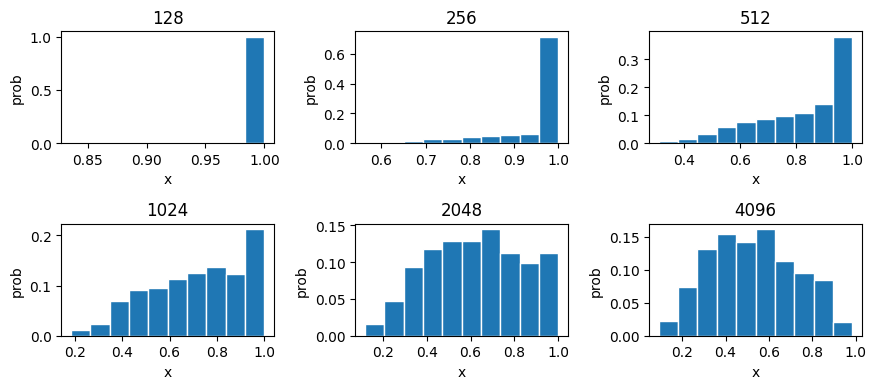

In [6]:
col = 3
plot_info = list(
    {k: np.array(hit_rate[k]) for k in ks[i:i+col]}
    for i in range(0, len(ks), col)
)
plot_hist_m(plot_info, None, n_bins=10, image_size=(3, 2))

Text(0, 0.5, 'freq')

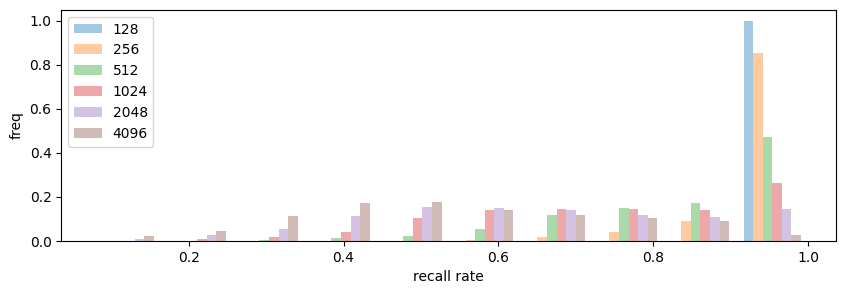

In [6]:
fig = plt.figure(figsize=(10, 3))
plt.hist(
    [np.array(v) for v in hit_rate.values()],
    bins=10,
    weights=[np.ones_like(np.ones_like(np_arr))/len(np_arr) for np_arr in hit_rate.values()],
    alpha=0.4
)
plt.legend(hit_rate.keys())
plt.xlabel("recall rate")
plt.ylabel("freq")
# plt.title("recall rate")

### 分析chunk内部是否有阈值

In [8]:
def analyze(data):
    ck_size = 4096
    k = 2048
    tp_size = 16
    res = chunk_topk(**data, version="v0")
    x = data['x'] / tp_size
    round_len = x.size(-1) // ck_size * ck_size
    mask = torch.zeros_like(x)
    mask.scatter_(-1, res.indices[..., :k], 1)
    score = x[..., :round_len] * mask[..., :round_len]
    score = rearrange(score, "... (m ck_size) -> ... m ck_size", ck_size=ck_size)
    score = score.sum(-1)
    useless_rate = (score == 0).float().mean().item()
    min_nonzero = score[score != 0].min().item()
    max_nonzero = score[score != 0].max().item()
    median = score[score != 0].view(-1).median().item()
    return useless_rate, min_nonzero, max_nonzero, median

In [9]:
data_dir = "/ssd01/workspace/sglang/exp/data/db_idx/"
useless_rates = list()
mini_nonzeros = list()
max_nonzeros = list()
medians = list()
for filename in sorted(os.listdir(data_dir))[:]:
    print('\r', filename, end="")
    data = torch.load(os.path.join(data_dir, filename), map_location="cpu")
    useless_rate, min_nonzero, max_nonzero, median = analyze(data)
    useless_rates.append(useless_rate)
    mini_nonzeros.append(min_nonzero)
    max_nonzeros.append(max_nonzero)
    medians.append(median)

print(useless_rates)

 x_000077.pt

/tmp/ipykernel_122714/2044584733.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(data_dir, filename), map_location="cpu")


 x_010001.pt[0.0, 0.0, 0.13793103396892548, 0.0, 0.517241358757019, 0.0, 0.2068965584039688, 0.0, 0.0, 0.0, 0.517241358757019, 0.0, 0.48275861144065857, 0.0, 0.8275862336158752, 0.0, 0.7241379022598267, 0.25, 0.24137930572032928, 0.0, 0.13793103396892548, 0.0, 0.6551724076271057, 0.0, 0.6551724076271057, 0.0, 0.7931034564971924, 0.0, 0.6551724076271057, 0.0, 0.1034482792019844, 0.0, 0.7241379022598267, 0.0, 0.03448275849223137, 0.0, 0.7586206793785095, 0.0, 0.27586206793785095, 0.0, 0.0, 0.0, 0.03448275849223137, 0.0, 0.48275861144065857, 0.0, 0.1034482792019844, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13793103396892548, 0.0, 0.06896551698446274, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03448275849223137, 0.0, 0.034482758492231

Text(0, 0.5, 'freq')

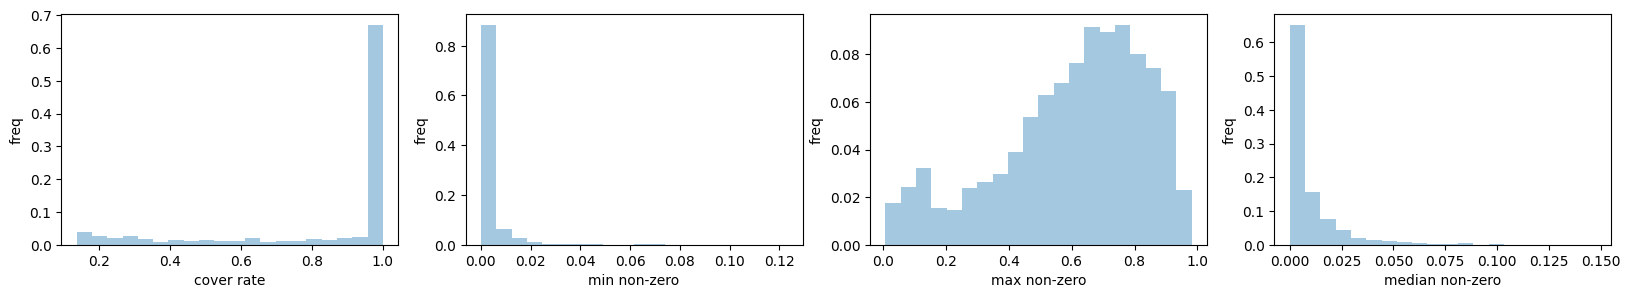

In [18]:
fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(1, 4, 1)
plt.hist(
    1 - np.array(useless_rates),
    bins=20,
    weights=np.ones_like(np.ones_like(useless_rates)) / len(useless_rates),
    alpha=0.4
)
plt.xlabel("cover rate")
plt.ylabel("freq")
ax = fig.add_subplot(1, 4, 2)
plt.hist(
    np.array(mini_nonzeros),
    bins=20,
    weights=np.ones_like(np.ones_like(mini_nonzeros)) / len(mini_nonzeros),
    alpha=0.4
)
plt.xlabel("min non-zero")
# plt.xscale("log")
plt.ylabel("freq")
ax = fig.add_subplot(1, 4, 3)
plt.hist(
    np.array(max_nonzeros),
    bins=20,
    weights=np.ones_like(np.ones_like(max_nonzeros)) / len(max_nonzeros),
    alpha=0.4
)
plt.xlabel("max non-zero")
plt.ylabel("freq")
ax = fig.add_subplot(1, 4, 4)
plt.hist(
    np.array(medians),
    bins=20,
    weights=np.ones_like(np.ones_like(medians)) / len(medians),
    alpha=0.4
)
plt.xlabel("median non-zero")
plt.ylabel("freq")

In [17]:
print(f"min of cover rate: \t{1 - max(useless_rates):.3f}")
print(f"min of min_nonzero: \t{min(mini_nonzeros):.3e}")
# print(f"max of min_nonzero: \t{max(mini_nonzeros):.3e}")
print(f"min of max_nonzero: \t{min(max_nonzeros):.3e}")
print(f"min of median_nonzero: \t{min(medians):.3e}")

min of cover rate: 	0.138
min of min_nonzero: 	2.383e-06
min of max_nonzero: 	8.138e-03
min of median_nonzero: 	1.173e-05


### 寻找最优的tau for v3.2

In [ ]:
# def compare_v3(data_path, v1, tau_list=np.arange(0, 1.05, 0.05), ks=[128, 256, 512, 1024, 2048, 4096]):
#     data = torch.load(data_path, map_location="cpu", weights_only=False)
def compare_v3(data, v1, tau_list=np.arange(0, 1.05, 0.05), ks=[128, 256, 512, 1024, 2048, 4096]):
    data['chunk_size'] = 4096
    data['mini_k'] = -1
    data['x'] = data['x'][:, :1]
    _, res_v1 = chunk_topk(**data, version=v1)
    hit_rate = defaultdict(lambda: defaultdict(float))
    retain_nums = defaultdict(list)
    for tau in tau_list:
        _, res_v2 = chunk_topk_v3(**data, tau=tau, distribute=True, adjust_k=True)
        retain_nums[tau].append(res_v2.size(-1))
        for k in ks:
            hit_rate[k][tau] = (res_v1[..., :k, None] == res_v2[..., None, :]).any(-1).float().mean().item()
            # print(f"k={k}, hit_rate={hit_rate[k]:.4f}")
    return hit_rate, retain_nums

In [3]:
# data_dir = "/ssd01/workspace/sglang/exp/data/db_idx/"
data_dir = "/ssd01/workspace/sglang/exp/data/db_idx-v0/"
dataset = [
    torch.load(data_path, map_location="cpu", weights_only=False) 
    for data_path in tqdm(
        glob.glob(os.path.join(data_dir, "*.pt"))[:], desc="Load data"
    )
]

Load data: 100%|██████████| 96380/96380 [00:33<00:00, 2859.26it/s]


In [4]:
ks = [128, 256, 512, 1024, 2048, 4096]
tau_list = np.arange(0, 10.1, 1) / 10
# tau_list = np.arange(0, 10.1, 1)
# tau_list = np.arange(0, 10.1, 1) + 10
hit_rate = defaultdict(lambda: defaultdict(list))
retain_nums = defaultdict(list)
# for filename in tqdm(sorted(os.listdir(data_dir))[:], desc="Process data"):
#     data_path = os.path.join(data_dir, filename)
#     # data = torch.load(data_path, map_location="cpu", weights_only=False)
#     hit_rate_item, retain_nums_item = compare_v3(data_path, "v0", tau_list=tau_list, ks=ks)
for data in tqdm(dataset[:], desc="Process data"):
    hit_rate_item, retain_nums_item = compare_v3(data, "v0", tau_list=tau_list, ks=ks)
    [hit_rate[k][tau].append(hit_rate_item[k][tau]) for k in ks for tau in tau_list]
    [retain_nums[tau].extend(retain_nums_item[tau]) for tau in tau_list]
'''
futures = list()
# with ProcessPoolExecutor(max_workers=int(os.cpu_count() // 2)) as executor:
# executor = ProcessPoolExecutor(max_workers=int(os.cpu_count() // 2))
# with ThreadPoolExecutor(max_workers=int(os.cpu_count() // 2)) as executor:
with ThreadPoolExecutor() as executor:
    # for filename in tqdm(sorted(os.listdir(data_dir))[:], desc="Add jobs"):
    #     data_path = os.path.join(data_dir, filename)
        # data = torch.load(data_path, map_location="cpu", weights_only=False)
        # hit_rate_item, retain_nums_item = compare_v3(data_path, "v0", tau_list=tau_list, ks=ks)
    for data in tqdm(dataset[:], desc="Add jobs"):
        futures.append(
            executor.submit(
                # partial(compare_v3, data_path, "v0", tau_list=tau_list, ks=ks)
                partial(compare_v3, data, "v0", tau_list=tau_list, ks=ks)
            )
        )
    # futures = [future.result() for future in tqdm(as_completed(futures), desc="Get results")]
    futures = [future.result() for future in tqdm(futures, desc="Get results")]
    for hit_rate_item, retain_nums_item in tqdm(futures, desc="Merge results"):
        [hit_rate[k][tau].append(hit_rate_item[k][tau]) for k in ks for tau in tau_list]
        [retain_nums[tau].extend(retain_nums_item[tau]) for tau in tau_list]
'''

Process data: 100%|██████████| 96380/96380 [1:35:16<00:00, 16.86it/s]


'\nfutures = list()\n# with ProcessPoolExecutor(max_workers=int(os.cpu_count() // 2)) as executor:\n# executor = ProcessPoolExecutor(max_workers=int(os.cpu_count() // 2))\n# with ThreadPoolExecutor(max_workers=int(os.cpu_count() // 2)) as executor:\nwith ThreadPoolExecutor() as executor:\n    # for filename in tqdm(sorted(os.listdir(data_dir))[:], desc="Add jobs"):\n    #     data_path = os.path.join(data_dir, filename)\n        # data = torch.load(data_path, map_location="cpu", weights_only=False)\n        # hit_rate_item, retain_nums_item = compare_v3(data_path, "v0", tau_list=tau_list, ks=ks)\n    for data in tqdm(dataset[:], desc="Add jobs"):\n        futures.append(\n            executor.submit(\n                # partial(compare_v3, data_path, "v0", tau_list=tau_list, ks=ks)\n                partial(compare_v3, data, "v0", tau_list=tau_list, ks=ks)\n            )\n        )\n    # futures = [future.result() for future in tqdm(as_completed(futures), desc="Get results")]\n    futur

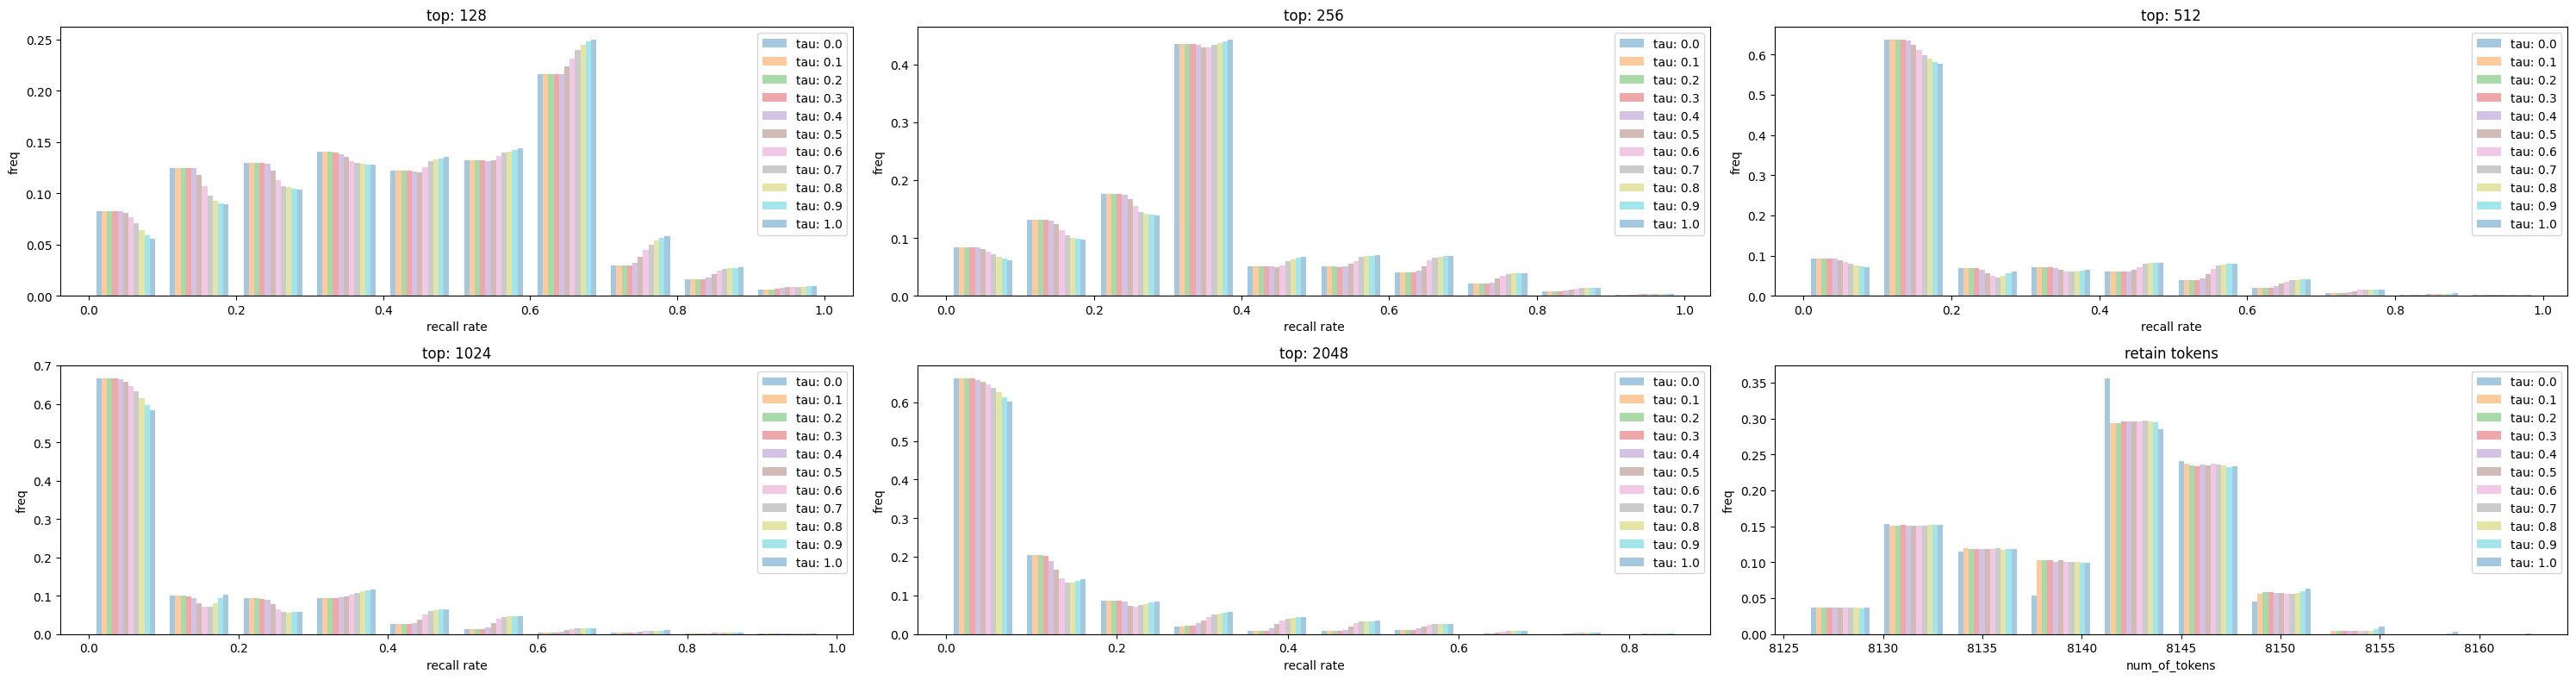

In [5]:
col = 3
row = int(np.ceil(len(ks)/col))
fig = plt.figure(figsize=(10*col, 4*row))
for i, k in enumerate(ks[:-1]):
    fig.add_subplot(row, col, i+1)
    plt.hist(
        [np.array(v) for v in hit_rate[k].values()],
        bins=10,
        weights=[np.ones_like(np.ones_like(np_arr))/len(np_arr) for np_arr in hit_rate[k].values()],
        alpha=0.4
    )
    plt.legend([f'tau: {tau}' for tau in hit_rate[k].keys()])
    plt.title(f"top: {k}")
    plt.xlabel("recall rate")
    plt.ylabel("freq")
    plt.tight_layout()
# plt.title("recall rate")

# retain nums
fig.add_subplot(row, col, row*col)
plt.hist(
    [np.array(v) for v in retain_nums.values()],
    bins=10,
    weights=[np.ones_like(np.ones_like(np_arr))/len(np_arr) for np_arr in retain_nums.values()],
    alpha=0.4
)
plt.legend([f'tau: {tau}' for tau in retain_nums.keys()])
plt.title(f"retain tokens")
plt.xlabel("num_of_tokens")
plt.ylabel("freq")
plt.tight_layout()

### 寻找最优的sk for v2.2

In [2]:
def compare_v2(data, v1, sks=range(5), ks=[128, 256, 512, 1024, 2048, 4096]):
    data['chunk_size'] = 64
    data['x'] = data['x'][:, :1]
    if 'mini_k' in data:
        data.pop('mini_k')
    _, res_v1 = chunk_topk(**data, version=v1)
    hit_rate = defaultdict(lambda: defaultdict(float))
    retain_nums = defaultdict(list)
    for sk in sks:
        _, res_v2 = chunk_topk_v2(**data, sk=sk)
        retain_nums[sk].append(res_v2.size(-1))
        for k in ks:
            hit_rate[k][sk] = (res_v1[..., :k, None] == res_v2[..., None, :]).any(-1).float().mean().item()
            # print(f"k={k}, hit_rate={hit_rate[k]:.4f}")
    return hit_rate, retain_nums

In [3]:
# data_dir = "/ssd01/workspace/sglang/exp/data/db_idx/"
data_dir = "/ssd01/workspace/sglang/exp/data/db_idx-v0/"
dataset = [
    torch.load(data_path, map_location="cpu", weights_only=False) 
    for data_path in tqdm(
        glob.glob(os.path.join(data_dir, "*.pt"))[:], desc="Load data"
    )
]

Load data: 100%|██████████| 96380/96380 [00:31<00:00, 3015.46it/s]


In [6]:
ks = [128, 256, 512, 1024, 2048, 4096]
sks = range(5)
hit_rate = defaultdict(lambda: defaultdict(list))
retain_nums = defaultdict(list)
# for filename in tqdm(sorted(os.listdir(data_dir))[:], desc="Process data"):
#     data_path = os.path.join(data_dir, filename)
#     # data = torch.load(data_path, map_location="cpu", weights_only=False)
#     hit_rate_item, retain_nums_item = compare_v2(data_path, "v0", sks=sks, ks=ks)
for data in tqdm(dataset[:], desc="Process data"):
    hit_rate_item, retain_nums_item = compare_v2(data, "v0", sks=sks, ks=ks)
    [hit_rate[k][sk].append(hit_rate_item[k][sk]) for k in ks for sk in sks]
    [retain_nums[sk].extend(retain_nums_item[sk]) for sk in sks]

Process data: 100%|██████████| 96380/96380 [31:53<00:00, 50.37it/s]


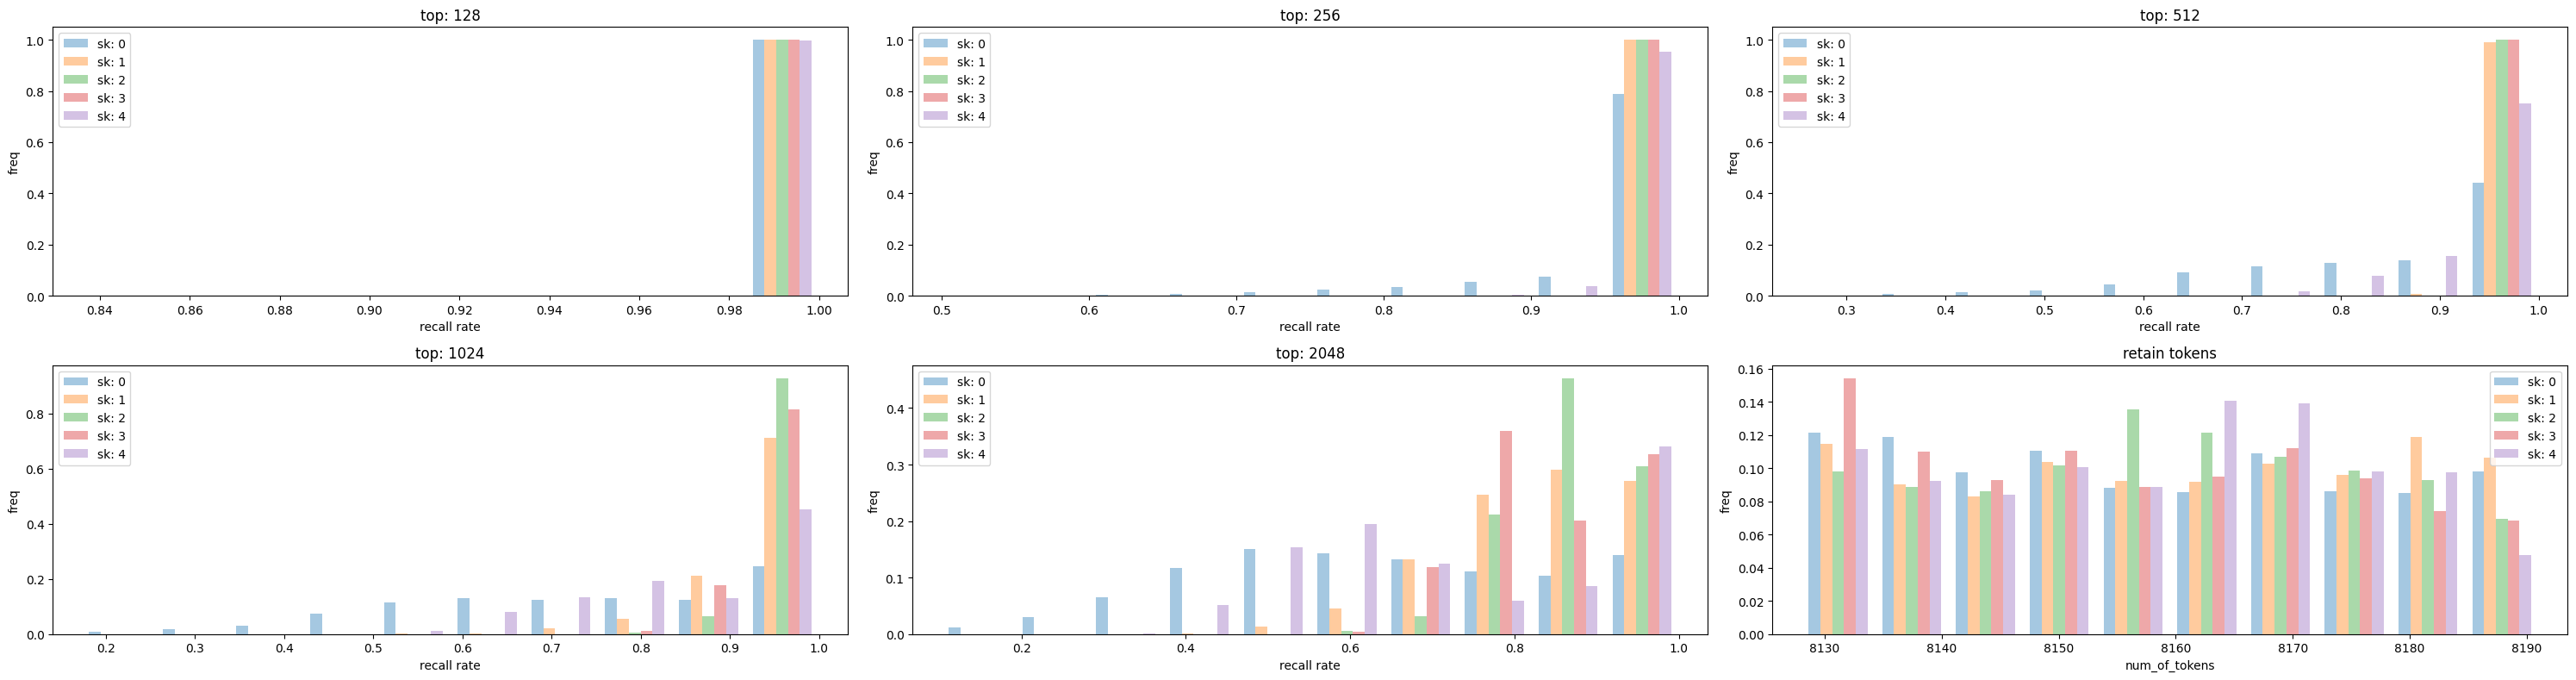

In [7]:
col = 3
row = int(np.ceil(len(ks)/col))
fig = plt.figure(figsize=(10*col, 4*row))
for i, k in enumerate(ks[:-1]):
    fig.add_subplot(row, col, i+1)
    plt.hist(
        [np.array(v) for v in hit_rate[k].values()],
        bins=10,
        weights=[np.ones_like(np.ones_like(np_arr))/len(np_arr) for np_arr in hit_rate[k].values()],
        alpha=0.4
    )
    plt.legend([f'sk: {sk}' for sk in hit_rate[k].keys()])
    plt.title(f"top: {k}")
    plt.xlabel("recall rate")
    plt.ylabel("freq")
    plt.tight_layout()
# plt.title("recall rate")

# retain nums
fig.add_subplot(row, col, row*col)
plt.hist(
    [np.array(v) for v in retain_nums.values()],
    bins=10,
    weights=[np.ones_like(np.ones_like(np_arr))/len(np_arr) for np_arr in retain_nums.values()],
    alpha=0.4
)
plt.legend([f'sk: {sk}' for sk in retain_nums.keys()])
plt.title(f"retain tokens")
plt.xlabel("num_of_tokens")
plt.ylabel("freq")
plt.tight_layout()